In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Reference for the data refered to as hughes in this code:
#
# Hughes, T. P. et al. Spatial and temporal patterns of mass bleaching of
# corals in the Anthropocene. Science 359, 80–83 (2018).

# Read data from the Hughes supplemental material.  The first
# sheet is a cut-and-paste from their document with obvious typos
# fixed by hand and a few columns added for easier data manipulation.
# The second sheet has been arranged for easier import.
filename = '../data/Hughes100Reefs.xlsx' 
hughes = pd.read_excel(filename,header=0,sheet_name=1, na_values='-')
# Missing size values are set to zero - be careful how they are used later!
# hughes.Size_km2 = hughes.Size_km2.replace({"-": "0"})

## Columns from Mumby et al. are
1. Hughes Reef - the index used in their data, 1-100.
2. Region - my code for their region labels.
    + AuA - Australasia
    + IO-ME - Indian Ocean/ Middle East
    + Pac - Pacific
    + WAtl - West Atlantic
3. Location - their location name for each reef. 
4. Numeric Lat - decimal values between about -35 and +35
5. Numeric Lon - decimal values between -180 and +180
6. Size_km2 - area in square kilometers, sometimes omitted.
7. Year - columns 7 to 43 - one column for each year of data, 1980 to 2016.  Values are blank, S, or M.
44. Severe count - the count of the number of cells in this row with the entry "S". values 0-7
45. Moderate count - the count of the number of cells in this row with the entry "M".  Values 0-12

In [3]:
# Now read our data for reef cell locations.
import scipy.io as sio

# Reference for all data for the 1,925 reef cell model.
# This has not been submitted to a journal yet, so all is subject to change:
#
# Logan, C. A., Dunne, J. P., Ryan, J. S., Baskett, M. L. & Donner, S. D. Can symbiont
# diversity and evolution allow corals to keep pace with global warming
# and ocean acidification? prep (2018).

# A copy of the data is in this repository.  The reference copy is in
# my Coral-Model-Data repository in the ProjectionsPaper directory.
mat_data = sio.loadmat('../data/ESM2M_SSTR_JD.mat')
# Put just the lat/lon columns into a data frame.  Note that they are stored
# with longitude first in the incoming data.
cells = pd.DataFrame(mat_data['ESM2M_reefs_JD'], columns=['Lon', 'Lat'])
del mat_data  # hope this gets garbage collected - it's big




<IPython.core.display.Javascript object>


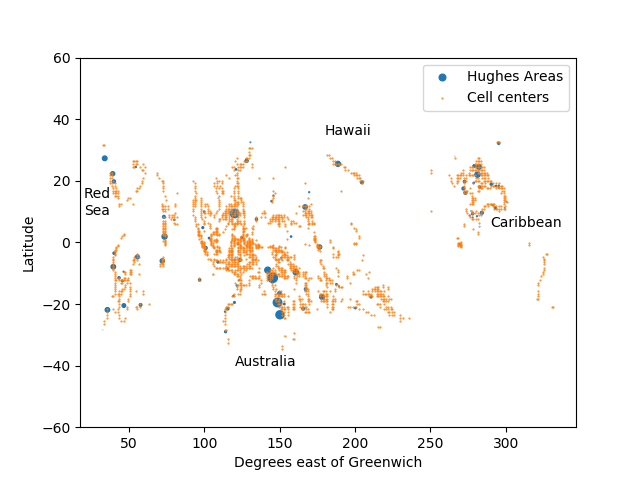

Text(180,35,'Hawaii')

In [4]:
plt.figure()
# Hughes reef areas can be large.  Make size proportional.  Conveniently, the marker
# size argument is in square units.  However, our map is in degree units and the areas
# are in kilometers.  This should be calculated carefully for map display, but for now
# just to a rough conversion.  The initial value relates to pixels per square degree.
conversion = 60*(1/111)**2

lon = hughes['Numeric Lon']
#plt.scatter(hughes['Numeric Lon'], hughes['Numeric Lat'], marker='o', s=conversion*hughes.Size_km2.astype(float))
plt.scatter(lon-180*(np.sign(lon)-1), hughes['Numeric Lat'], marker='o', s=conversion*hughes.Size_km2.astype(float), label='Hughes Areas')
# Mark our cells with small dots.
# scatter is broken so that the "," argument to plot pixels is ignored.
# use s=1 to make a very small dot.
lon = cells['Lon']
plt.scatter(lon-180*(np.sign(lon)-1), cells['Lat'], marker='.', s=1, label='Cell centers')
plt.ylim([-60, 60])
plt.xlabel('Degrees east of Greenwich')
plt.ylabel('Latitude')
plt.legend()
plt.text(290, 5, 'Caribbean')
plt.text(120, -40, 'Australia')
plt.text(20, 9, 'Red\nSea')
plt.text(180, 35, 'Hawaii')

<IPython.core.display.Javascript object>


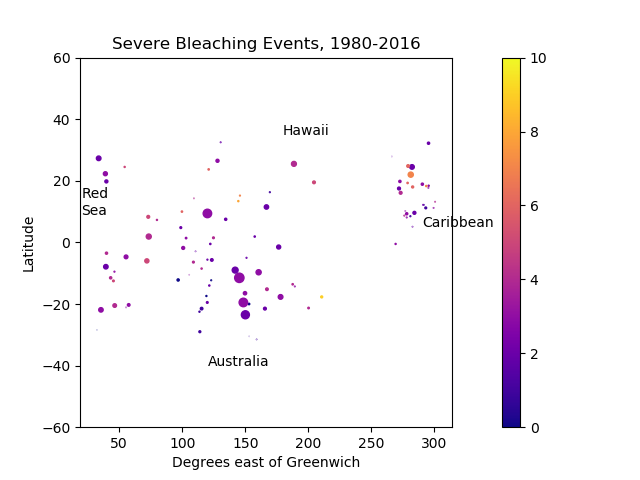

In [5]:
# Now try an indication of bleaching severity.

plt.figure()
conversion = 60*(1/111)**2
lon = hughes['Numeric Lon']
severity = hughes['Severe count']
plt.scatter(lon-180*(np.sign(lon)-1), hughes['Numeric Lat'], marker='o', 
            s=conversion*hughes.Size_km2.astype(float),
            label='Hughes Areas',
            c=severity,
            cmap="plasma")

plt.ylim([-60, 60])
plt.xlabel('Degrees east of Greenwich')
plt.ylabel('Latitude')
plt.title('Severe Bleaching Events, 1980-2016')
plt.clim(0, 10)
plt.colorbar(pad=0.10)
plt.text(290, 5, 'Caribbean')
plt.text(120, -40, 'Australia')
plt.text(20, 9, 'Red\nSea')
plt.text(180, 35, 'Hawaii');

<IPython.core.display.Javascript object>


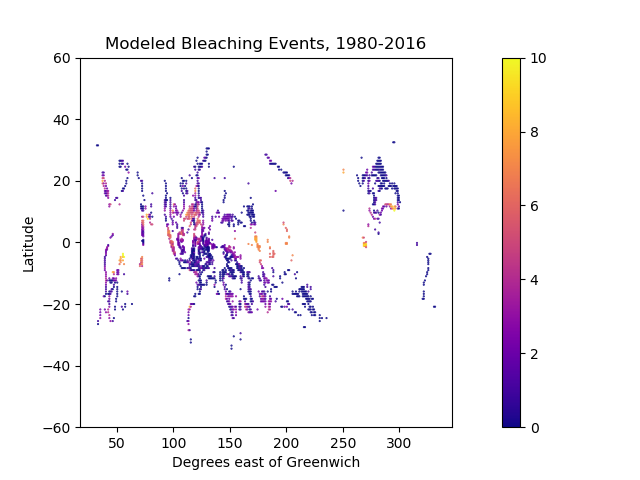

In [6]:
# Look at Bleaching events from the numerical model, using the same scale as the previous plot of Hughes data.

mat_data = sio.loadmat('../data/HughesCompEvents_selV_rcp60E=1OA=1.mat')
# Put the bleaching counts into a data frame.
modelBleaching = pd.DataFrame(mat_data['events80_2016'])
modelBleaching.rename(columns={0: 'Events'}, inplace=True)
del mat_data
plt.figure()
conversion = 60*(1/111)**2

lon = cells['Lon']
plt.scatter(lon-180*(np.sign(lon)-1), cells['Lat'], c = modelBleaching['Events'], marker='.', s=1, label='Events', cmap="plasma")
plt.ylim([-60, 60])
plt.xlabel('Degrees east of Greenwich')
plt.ylabel('Latitude')
plt.title('Modeled Bleaching Events, 1980-2016')
plt.clim(0, 10)
plt.colorbar(pad=0.10)

In [7]:
cells.head()

,Lon,Lat
0,-179.5,-19.145246
1,-179.5,-18.311912
2,-179.5,-17.500333
3,-179.5,-16.710136
4,-179.5,-15.940584


In [8]:
# To make a fair comparison, we need to figure out which of our cells match Hughes reef areas.
# Each area has a center and an area, so we can use a circle of that area as a first-order guess
# at each area.  Unfortunately, it seems that the areas are quite warped, because some of the 
# centers are far inland.

# Try scipy.spatial.cKDTree to find neighbors.
from scipy import spatial
# Build the tree (a binary trie) of our cells.
lonlat = cells.as_matrix({'Lon', 'Lat'})
tree = spatial.cKDTree(lonlat)

# For each of the 100 Hughes cells, get a list of our cells which are likely to overlap.
# I failed to find a way to add variable-length lists to a column, so the lists are stored
# separately.
hughes = hughes.assign(radius_km=hughes.Size_km2**0.5)
cell_lists = [ [] for i in range(len(hughes)) ]
match_idx = np.zeros(len(hughes), dtype=np.bool)
for i in range(len(hughes)):
    # convert radius to degrees (ignoring change of size with latitude for now)
    # also, add 0.2 km as a rough allowance for our cell size
    radius = 0.25 + hughes.radius_km[i] / 111
    c = tree.query_ball_point([hughes['Numeric Lon'][i],hughes['Numeric Lat'][i]], radius, n_jobs=4)
    # Convert zero-based indexes to 1-based cell numbers.
    cell_lists[i] = [x+1 for x in c]
    match_idx[i] = len(c) > 0

print(cell_lists)

[[1601], [], [1578, 1579], [1513, 1512], [], [], [], [], [961], [], [], [], [], [], [], [994], [1197], [], [], [1267], [], [1232, 1233], [813, 814], [], [1357, 1342], [], [], [1107, 1108, 1136, 1135], [1759, 1758], [], [], [], [], [851], [762], [1086], [1148], [657, 666], [553], [], [706], [], [], [], [695, 696], [636], [566], [477], [502], [], [624, 625], [572], [], [], [492, 493], [], [71], [], [1540], [], [], [], [1913], [144], [240], [1525], [126], [70], [], [1903, 1904], [], [1785], [1457, 1458], [], [], [1811, 1810], [57], [1818], [343], [445], [], [422], [402], [420], [301], [], [], [], [], [], [311], [], [265], [339], [261], [], [], [], [440], []]


In [9]:
# Now that we have a correspondence between Hughes areas and Logan cells, we can
# compare the bleaching for those which have some overlap.
# Add a column for cell-based bleaching values
hughes = hughes.assign(cell_bleach=np.zeros(len(hughes)))
for i in range(len(hughes)):
    if len(cell_lists[i]) > 0:
        count = 0;
        for n in cell_lists[i]:
            count = count + modelBleaching.loc[n, 'Events']
        hughes.loc[i, 'cell_bleach'] = count / len(cell_lists[i])


<IPython.core.display.Javascript object>


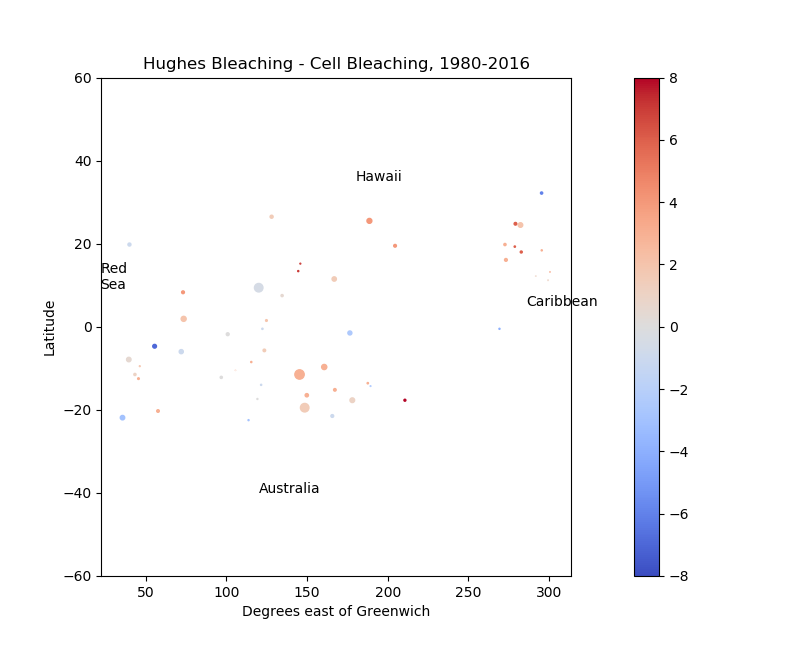

In [10]:
# Plot the Hughes reefs, but only those which Logan cells to compare to.
# Color the markers by the ratio between the two bleaching values.
plt.figure()
conversion = 60*(1/111)**2
lon = hughes[match_idx]['Numeric Lon']
severity = hughes[match_idx]['Severe count'] - hughes[match_idx]['cell_bleach']
# Both zero counts as a ratio of 1.
severity[np.isnan(severity)] = 1  
# Divide by zero is arbitrarily 12.  FIND A BETTER COMPARISON!
severity[np.isinf(severity)] = 12
plt.scatter(lon-180*(np.sign(lon)-1), hughes[match_idx]['Numeric Lat'], marker='o', 
            s=conversion*hughes[match_idx].Size_km2.astype(float),
            label='Hughes Areas',
            c=severity,
            cmap="coolwarm")

plt.ylim([-60, 60])
plt.xlabel('Degrees east of Greenwich')
plt.ylabel('Latitude')
plt.title('Hughes Bleaching - Cell Bleaching, 1980-2016')
plt.clim(-8, 8)
plt.colorbar(pad=0.10)
plt.text(286, 5, 'Caribbean')
plt.text(120, -40, 'Australia')
plt.text(22, 9, 'Red\nSea')
plt.text(180, 35, 'Hawaii');

<IPython.core.display.Javascript object>


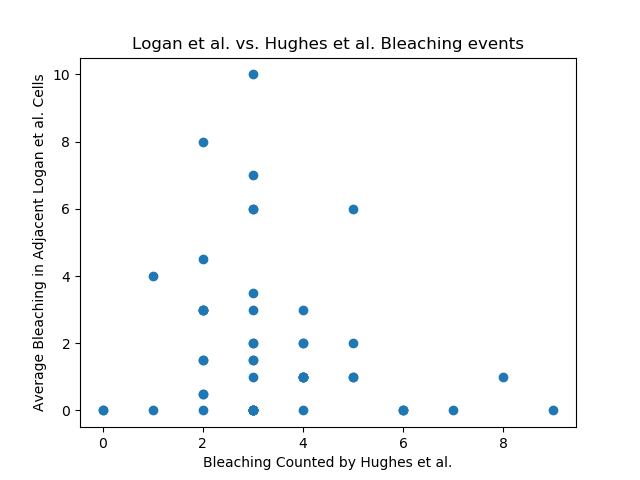

In [11]:
# That doesn't look great.  What is the correlation?
plt.figure()
plt.plot(hughes[match_idx]['Severe count'], hughes[match_idx]['cell_bleach'], 'o')
plt.xlabel('Bleaching Counted by Hughes et al.')
plt.ylabel('Average Bleaching in Adjacent Logan et al. Cells')
plt.title('Logan et al. vs. Hughes et al. Bleaching events');

### Conclusions so far
The comparison between the two datasets isn't looking good.  There are a few likely next things to do:
-  Scale the Hughes et al. bleaching counts by area.
-  Try to better understand their methods.  How are actual bleaching and observational effort likely to play into the status of an area as severely or moderately bleached?
-  Ask Terry Hughes for a definition of their areas, so they can be treated more accurately.  When seen on a map, it's clear that they are not circles.
- time series
- histogram of differences
- collapse latitude or some other dimension.